In [21]:
# Group number 1
# Assignment 11: Joint assimilation of navigation data coming from different sources
# Team members: Stepan Perminov, Polina Ponomareva, Kirill Shcherbakov, Daniil Svirskiy

# Library importing
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv

In [22]:
# Generation of a true trajectory in cartesian and polar coordinates, and measurements
class Trajectory(object):
    def __init__(self, N, T, Xc0, Vc0, sD2, sb2, sa2, a, sbadd2):
        
        # Trajectories
        self.Xc = self.true_c_trajectory(N, T, Xc0, Vc0, sa2, a)
        self.Xp = self.true_p_trajectory(N, self.Xc)
        self.Zp = self.measurements(N, self.Xp, sD2, sb2, sbadd2)
   
    def true_c_trajectory(self, n, T, Xc0, Vc0, sa2, a):
        Xc = np.zeros((2,n))
        Vc = np.zeros((2,n))

        Xc[:, 0] = Xc0
        Vc[:, 0] = Vc0
       
        for i in range(1,n):
            Vc[:, i] = Vc[:, i-1] + a[:, i-1]*T
            Xc[:, i] = Xc[:, i-1] + Vc[:, i-1]*T + (a[:, i-1]*T*T)/2
        return Xc
    
    def true_p_trajectory(self, n, Xc):
        Xp = np.zeros((2,n))
        # Range D
        Xp[0,:] = np.sqrt(Xc[0,:]**2 + Xc[1,:]**2)
        # Betta
        Xp[1,:] = np.arctan(Xc[0,:]/Xc[1,:]) #bet
        return Xp

    def measurements(self, n, Xp, sD2, sb2, sbadd2):
        Zp = np.zeros((2,n))
        # Range D (observer 1)
        Zp[0,:] = Xp[0,:] + np.random.normal(0, np.sqrt(sD2), n)
        # Betta (observer 1)
        Zp[1,:] = Xp[1,:] + np.random.normal(0, np.sqrt(sb2), n)
        # Betta (observer 2)
        badd = Xp[1,:] + np.random.normal(0, np.sqrt(sbadd2), n)
        
        # Generation of combined measurements
        key = 0
        for i in range(n):
            if key == 1:
                Zp[0,i] = float('nan')
                if i > 2:
                    Zp[1,i] = badd[i]
                else:
                    Zp[1,i] = float('nan')
                key = 0
            else:
                key = 1
        
        return Zp

In [23]:
# Kalman filter algorithm
class Filtration(object):
    def __init__(self, Zp, N, T, sD2, sb2, sa2, sbadd2):

        # Initial conditions for Kalman filter algorithm
        X0 = np.array([Zp[0, 2]*np.sin(Zp[1, 2]), (Zp[0, 2]*np.sin(Zp[1, 2]) - Zp[0, 0]*np.sin(Zp[1, 0]))/(2*T), Zp[0, 2]*np.cos(Zp[1, 2]), (Zp[0, 2]*np.cos(Zp[1, 2]) - Zp[0, 0]*np.cos(Zp[1, 0]))/(2*T)])
        P0 = np.eye(4)*(10**4)
        
        # Matrixes for filtering
        F = np.array([[1, T, 0, 0], [0, 1, 0, 0], [0, 0, 1, T], [0, 0, 0, 1]])
        G = np.array([[T*T/2, 0], [T, 0], [0, T*T/2], [0, T]])
        Q = G.dot(G.T)*sa2
        
        # Covariance matrix of measurement errors R
        # For observer 1
        R1 = np.array([[sD2, 0], [0, sb2]])
        # For observer 2
        R2 = sbadd2
        
        self.Kalman = self.Kalman_filtration(N, P0, X0, F, R1, R2, Q, Zp)
             
    def Kalman_filtration(self, n, P0, X0, F, R1, R2, Q, Zp):
        # Initialization of matrices
        P_1 = np.zeros((4,4,n))
        X_1 = np.zeros((4,n))
        P_ = np.zeros((4,4,n))
        X_ = np.zeros((4,n))

        # Initial filtration error covariance matrix P0 for filtering
        P_[:,:,3] = P0

        # Initial state vector X0 for filtering
        X_[:,3] = X0
        
        key = 0

        # Kalman filtering
        for i in range(4,n):
            P_1[:,:,i] = (F.dot(P_[:,:,i-1])).dot(F.T) + Q

            X_1[:,i] = F.dot(X_[:,i-1].reshape(4,1)).reshape(4)
            
            # The case of even time steps (improved betta measurements are available only)
            if key == 1:
                dh = (np.array([X_1[2,i]/(X_1[0,i]**2 + X_1[2,i]**2), 0, -X_1[0,i]/(X_1[0,i]**2 + X_1[2,i]**2), 0])).reshape(1,4)
                K = (P_1[:,:,i].dot(dh.reshape(4,1)))/((dh.dot(P_1[:,:,i])).dot(dh.reshape(4,1)) + R2) #4 x 1
                
                bet = np.arctan(X_1[0,i]/X_1[2,i])
                X_[:,i] = (X_1[:,i].reshape(4,1) + K.dot(Zp[1,i] - bet)).reshape(4)
                P_[:,:,i] = P_1[:,:,i] - (K.dot(dh)).dot(P_1[:,:,i])
                
                key = 0

            else:
            # The case of odd time steps (both D and betta measurements are available)                  
                dh = np.array([[X_1[0,i]/np.sqrt(X_1[0,i]**2 + X_1[2,i]**2), 0, X_1[2,i]/np.sqrt(X_1[0,i]**2 + X_1[2,i]**2), 0], [X_1[2,i]/(X_1[0,i]**2 + X_1[2,i]**2), 0, -X_1[0,i]/(X_1[0,i]**2 + X_1[2,i]**2), 0]])              
                K = (P_1[:,:,i].dot(dh.T)).dot(inv((dh.dot(P_1[:,:,i])).dot(dh.T) + R1)) #4 on 2
            
                D = np.sqrt(X_1[0,i]**2 + X_1[2,i]**2)
                bet = np.arctan(X_1[0,i]/X_1[2,i])
                h = np.array([D, bet])

                X_[:,i] = (X_1[:,i].reshape(4,1) + K.dot(Zp[:,i].reshape(2,1) - h.reshape(2,1))).reshape(4)
                P_[:,:,i] = P_1[:,:,i] - (K.dot(dh)).dot(P_1[:,:,i])
                
                key = 1
       
        X_est = np.zeros((4,n))
        X_est[0,:] = np.sqrt(X_1[0,:]**2 + X_1[2,:]**2)
        X_est[1,:] = np.arctan(X_1[0,:]/X_1[2,:])
        X_est[2,:] = np.sqrt(X_[0,:]**2 + X_[2,:]**2)
        X_est[3,:] = np.arctan(X_[0,:]/X_[2,:])
        
        # print(X_est[1,:])
        
        return X_est

In [24]:
# Parameters / Inputs
N = 500 #points
T = 2 #interval between measurements
# Initial coordinates and components of velocity
Xc_init = np.ones(2)*1000
Vc_init = np.ones(2)*100
# Variances
# For an acceleration
sigma_a2 = 0.3**2
# For a range
sigma_D2 = 50**2
# For betta values obtained from observer 1
sigma_b2 = 0.004**2
# For betta values obtained from observer 2
sigma_badd2 = 0.001**2


/home/steplerchik/PycharmProjects/Ass10/venv/lib/python2.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in divide
/home/steplerchik/PycharmProjects/Ass10/venv/lib/python2.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in divide


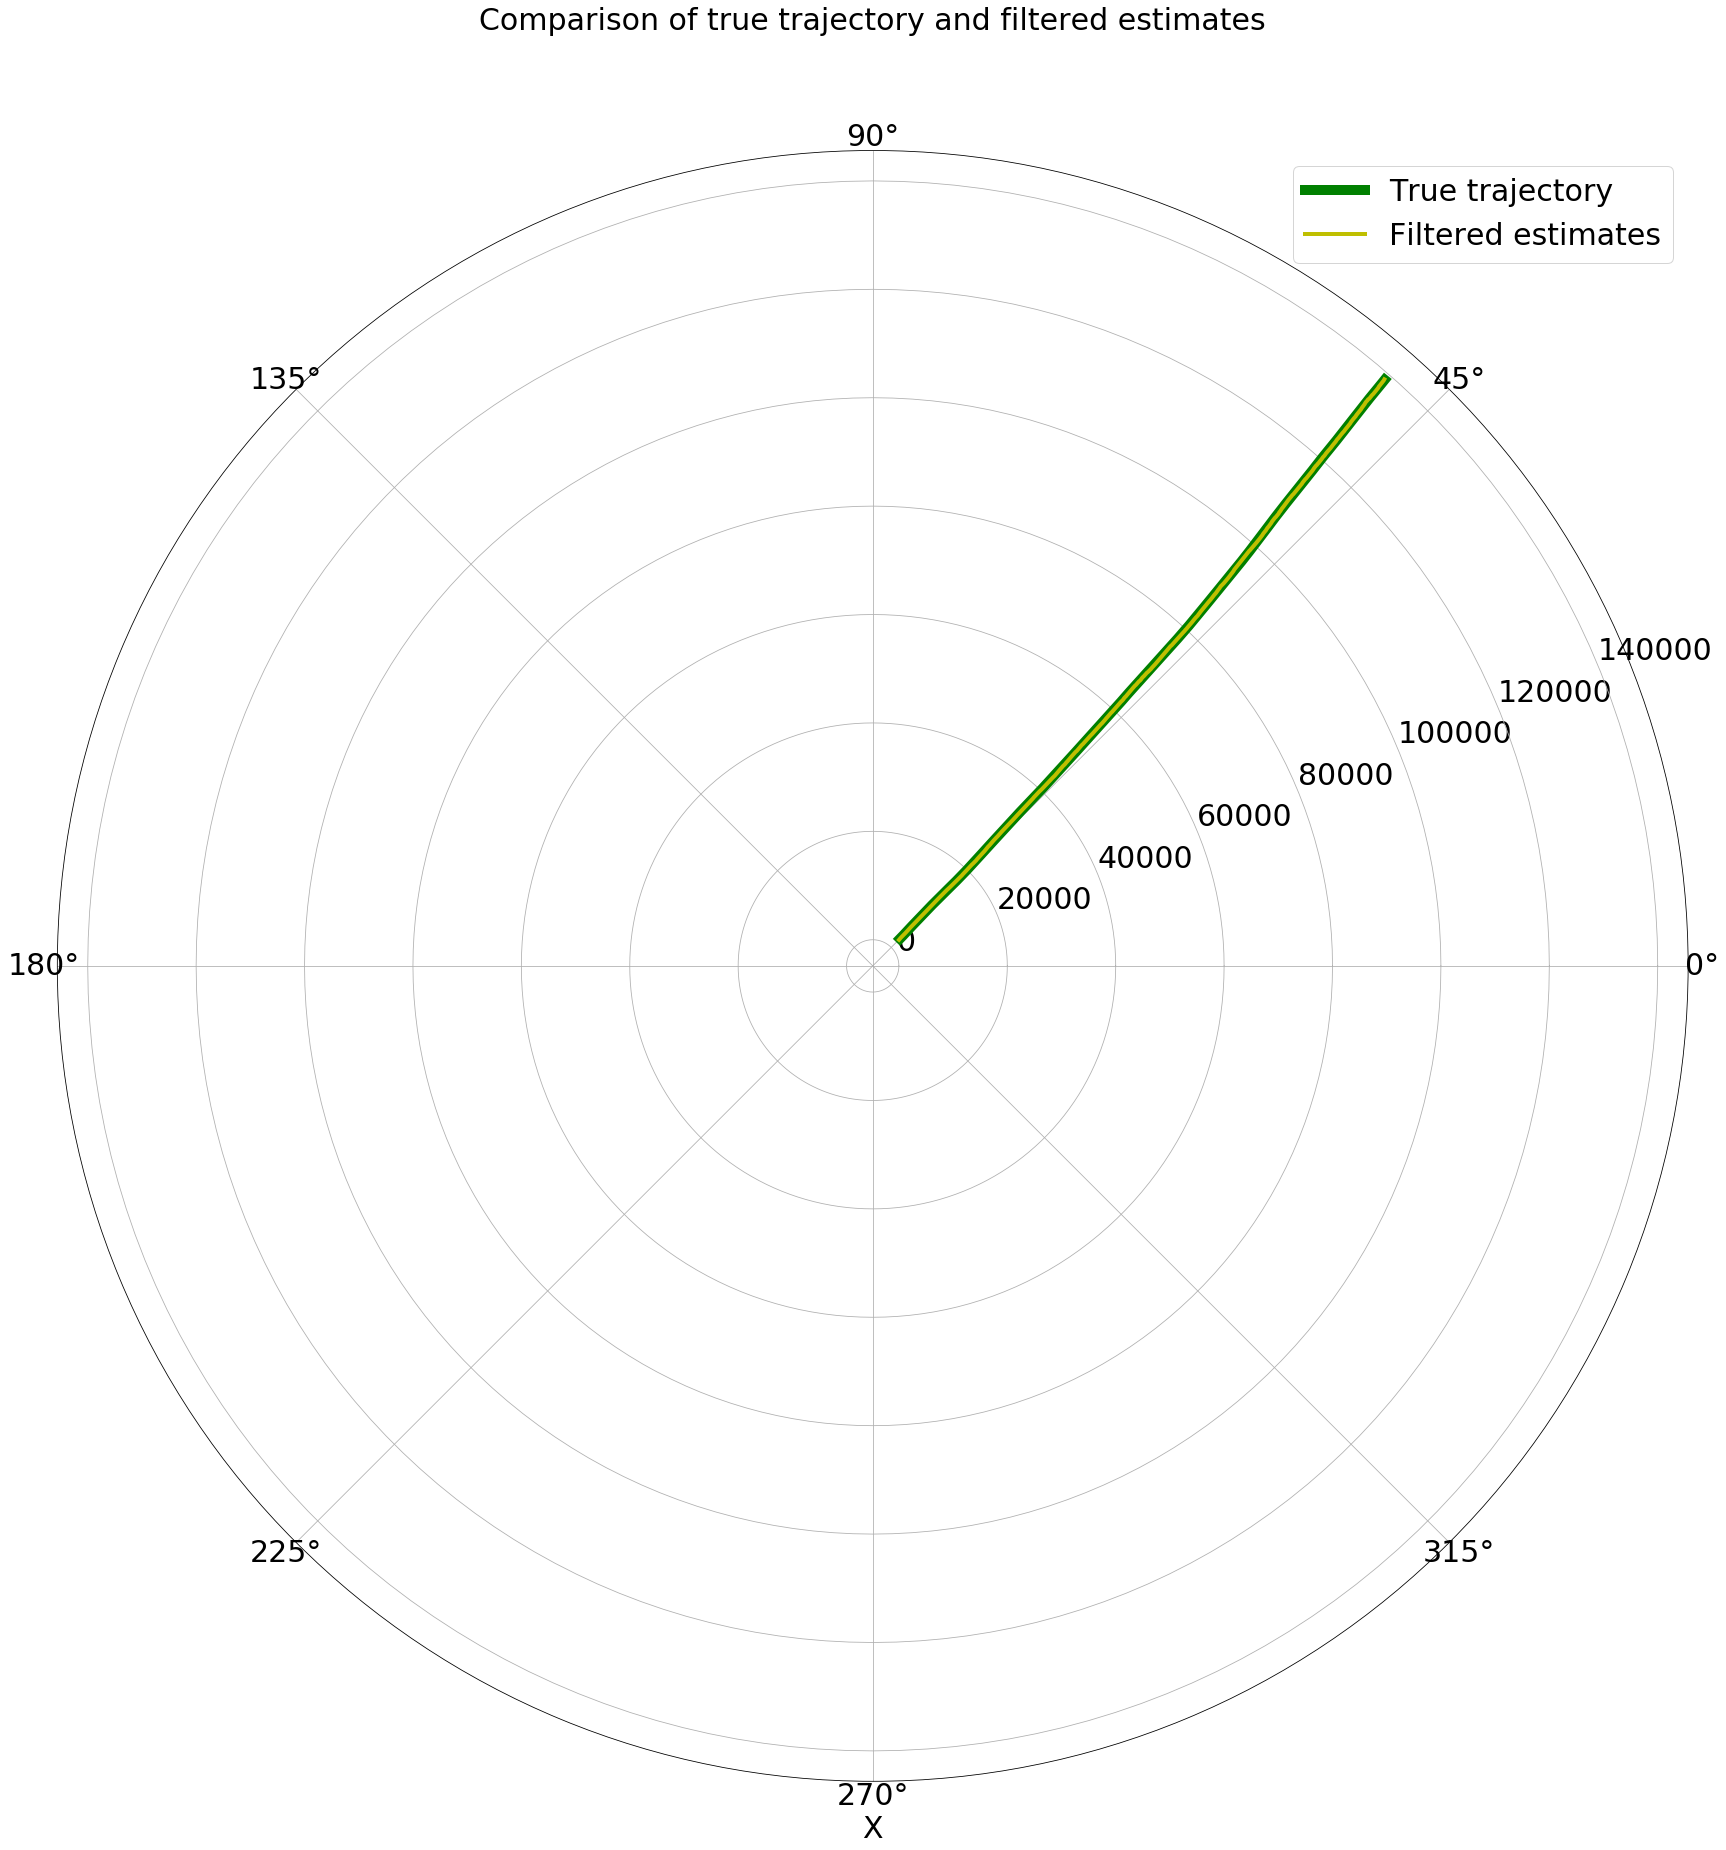

In [25]:
if __name__ == "__main__":
    # Acceleration generation
    a = np.zeros((2,N))
    a[0,:] = np.random.normal(0, np.sqrt(sigma_a2), N)
    a[1,:] = np.random.normal(0, np.sqrt(sigma_a2), N)
    
    # True trajectory generation
    Xp = Trajectory(N, T, Xc_init, Vc_init, sigma_D2, sigma_b2, sigma_a2, a, sigma_badd2).Xp
    # Measurements generation
    Zp = Trajectory(N, T, Xc_init, Vc_init, sigma_D2, sigma_b2, sigma_a2, a, sigma_badd2).Zp
    
    # Extrapolated and filtered estimates
    Ans = Filtration(Zp, N, T, sigma_D2, sigma_b2, sigma_a2, sigma_badd2).Kalman
    
    # Plot of true trajectory
    plt.polar(Xp[1,3:],Xp[0,3:], linewidth = 10, label = "True trajectory", color = "g")
    # Plot of filtered estimates
    plt.polar(Ans[3,3:],Ans[2,3:], linewidth = 4, label = "Filtered estimates", color = "y")

    plt.legend(fontsize = 30)
    plt.rcParams["figure.figsize"] = (20,20)
    plt.tick_params(labelsize = 30)
    plt.xlabel("X", fontsize = 30)
    plt.title("Comparison of true trajectory and filtered estimates\n", fontsize = 30)
    plt.show()


In [26]:
if __name__ == "__main__":
    
    # Set errors as default
    Error_filt = np.zeros((2,N,500))
    Error_extr = np.zeros((2,N,500))
    
    for k in range(500):
        a = np.zeros((2,N))
        a[0,:] = np.random.normal(0, np.sqrt(sigma_a2), N)
        a[1,:] = np.random.normal(0, np.sqrt(sigma_a2), N)
        
        Xp = Trajectory(N, T, Xc_init, Vc_init, sigma_D2, sigma_b2, sigma_a2, a, sigma_badd2).Xp
        Zp = Trajectory(N, T, Xc_init, Vc_init, sigma_D2, sigma_b2, sigma_a2, a, sigma_badd2).Zp
        
        Ans = Filtration(Zp, N, T, sigma_D2, sigma_b2, sigma_a2, sigma_badd2).Kalman
        
        est_filt = Ans[2:,:]
        est_extr = Ans[:2,:]
        Error_filt[:,:,k] = (Xp - est_filt)**2
        Error_extr[:,:,k] = (Xp - est_extr)**2

    # Final true errors of filtered and extrapolated estimates correspondingly
    Final_err_filt = np.sqrt(np.sum(Error_filt, axis = 2)/(500.0-1.0))
    Final_err_extr = np.sqrt(np.sum(Error_extr, axis = 2)/(500.0-1.0))

/home/steplerchik/PycharmProjects/Ass10/venv/lib/python2.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in divide
/home/steplerchik/PycharmProjects/Ass10/venv/lib/python2.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in divide


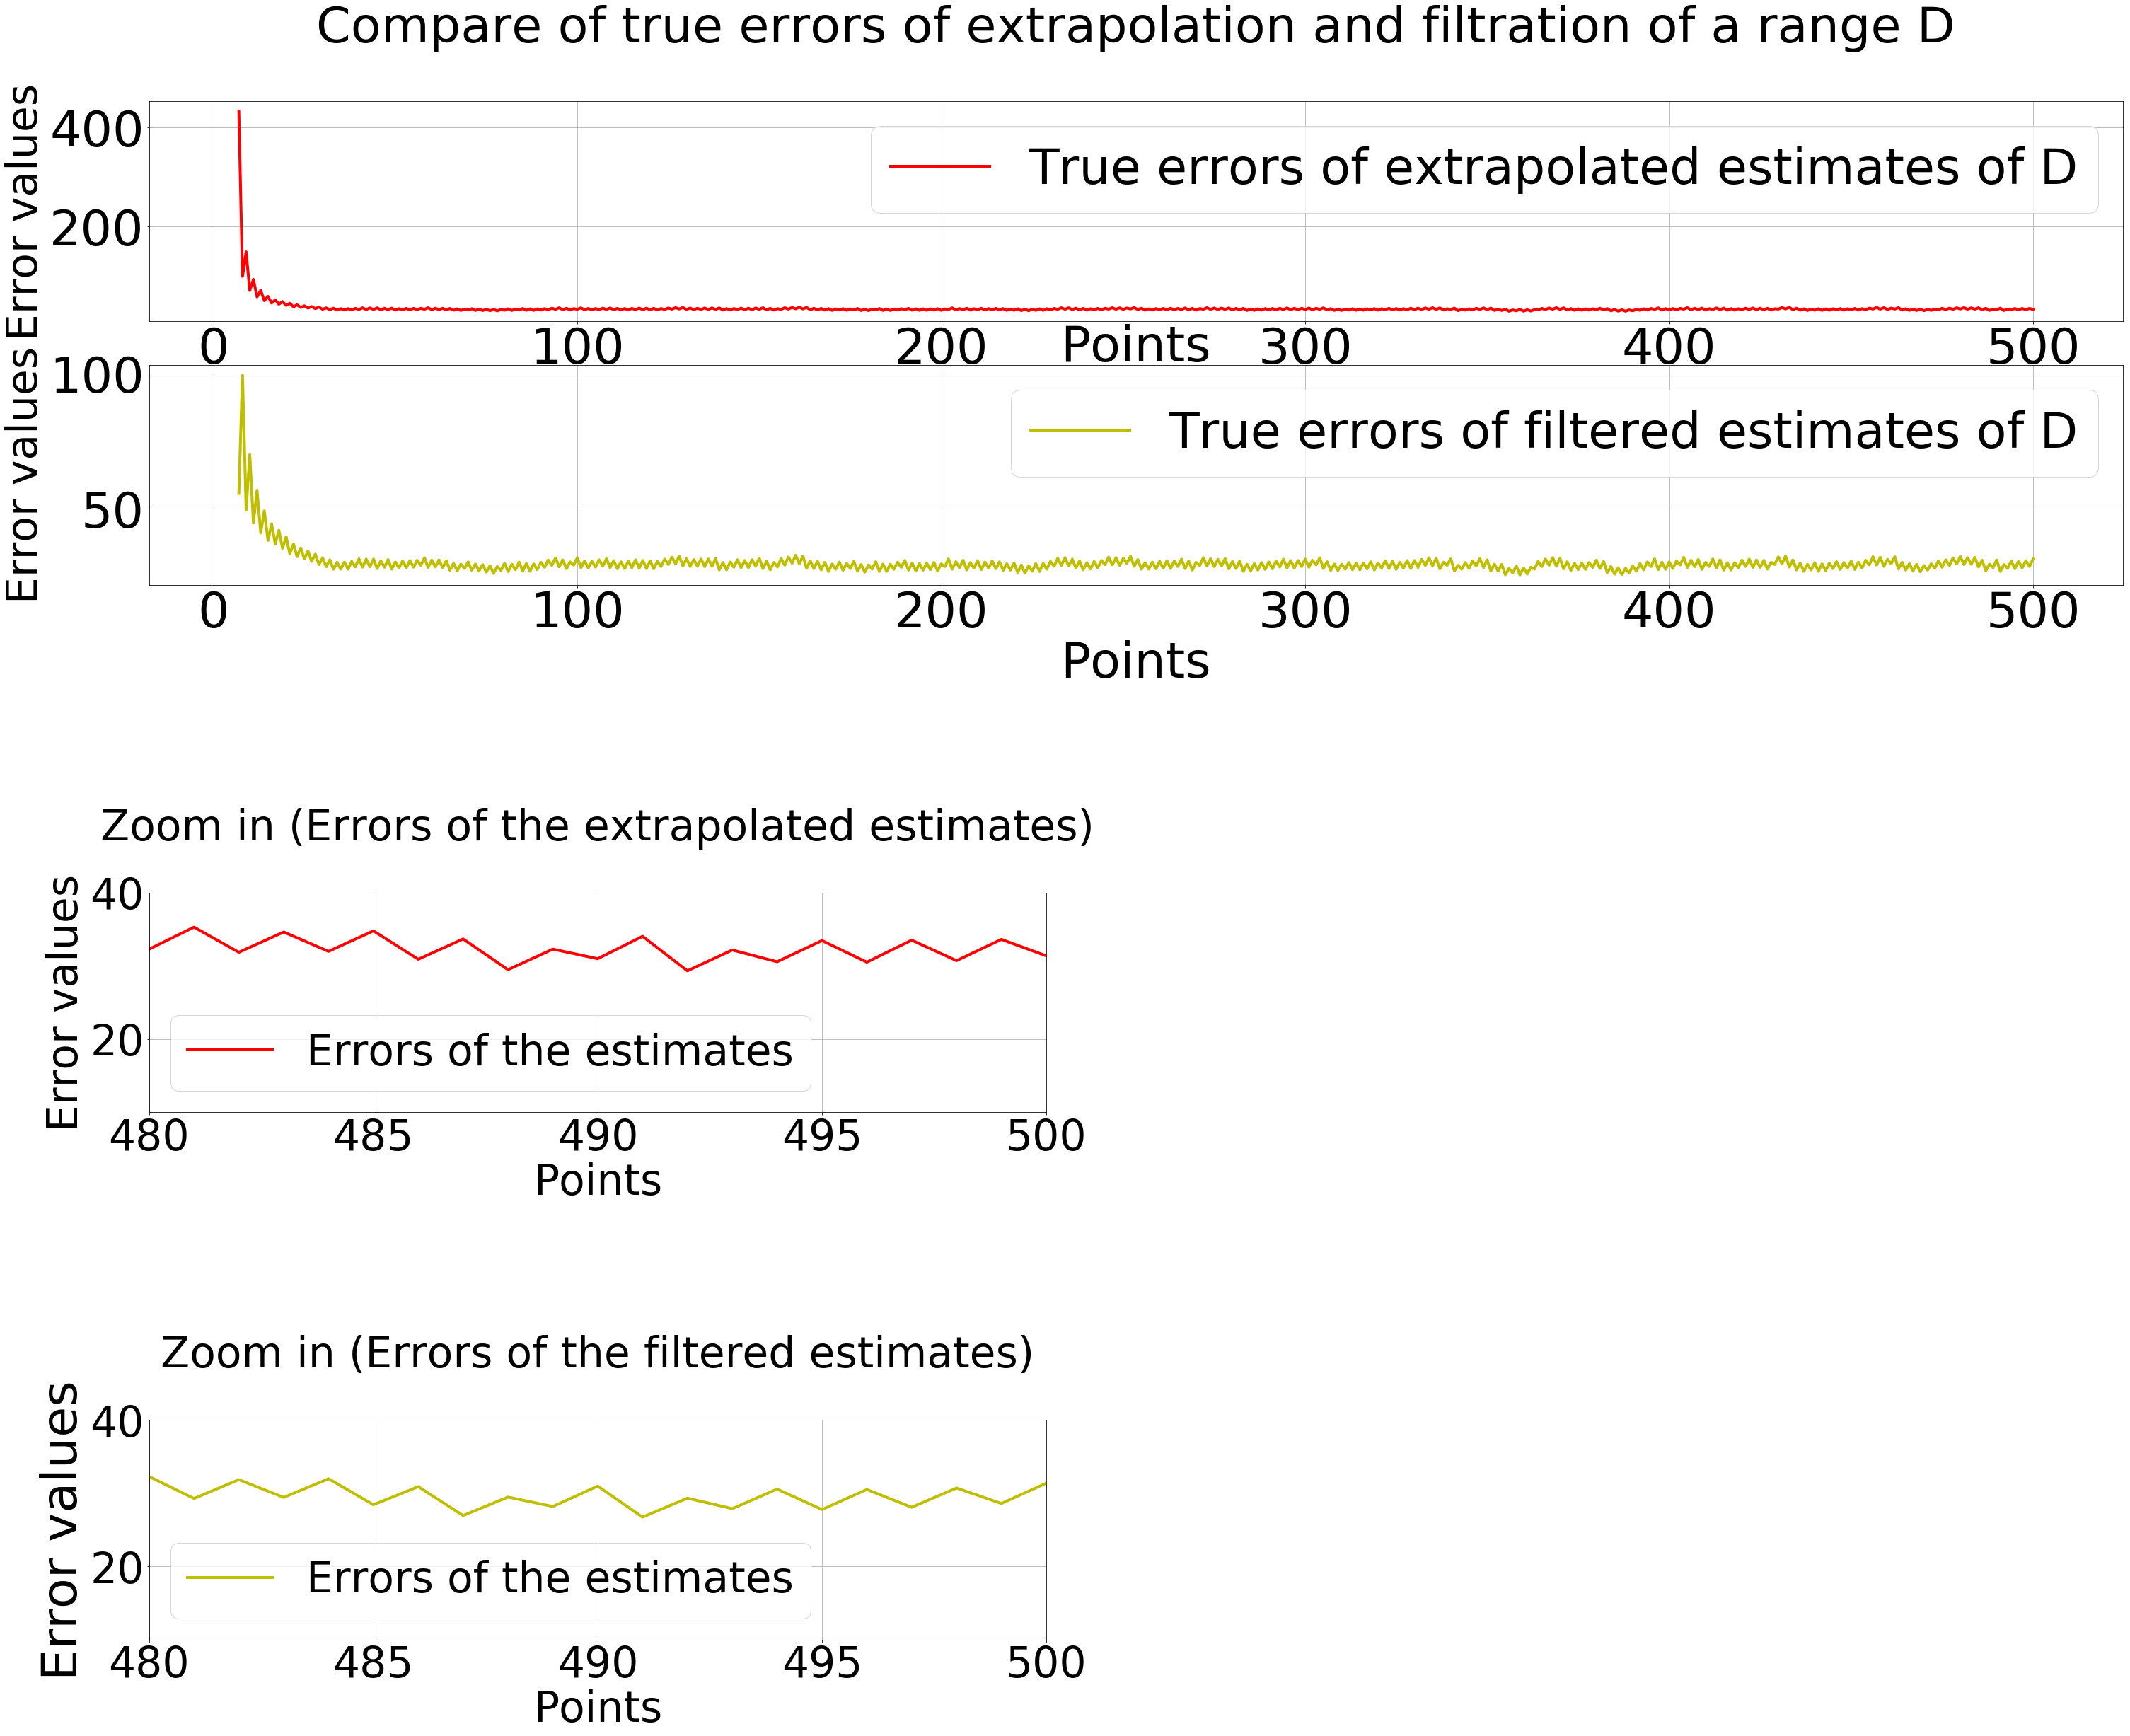

In [32]:
#Compare of true errors of extrapolation and filtration of a range D
points = range(1,N+1)
fig= plt.figure(1)

plt.subplot(612)
plt.plot(points[6:], Final_err_filt[0,6:], linewidth = 4, label = "True errors of filtered estimates of D", color = "y")

plt.legend(fontsize = 70)
plt.rcParams["figure.figsize"] = (50,40)
plt.tick_params(labelsize = 70)
plt.grid()
plt.ylabel("Error values", fontsize = 60)
plt.xlabel("Points", fontsize = 70)
plt.title("Points", fontsize = 70)

plt.subplot(627)
plt.plot(points[6:], Final_err_extr[0,6:], linewidth = 4, label = "Errors of the estimates", color = "r")
plt.legend(fontsize = 60)
plt.rcParams["figure.figsize"] = (50,40)
plt.tick_params(labelsize = 60)
plt.ylabel("Error values", fontsize = 60)
plt.grid()
plt.xlim([480,500])
plt.ylim([10,40])
plt.xlabel("Points", fontsize = 60)
plt.title("Zoom in (Errors of the extrapolated estimates)\n", fontsize = 60)

plt.subplot(6,2,11)
plt.plot(points[6:], Final_err_filt[0,6:], linewidth = 4, label = "Errors of the estimates", color = "y")
plt.legend(fontsize = 60)
plt.rcParams["figure.figsize"] = (50,40)
plt.tick_params(labelsize = 60)
plt.grid()
plt.xlim([480,500])
plt.ylim([10,40])
plt.xlabel("Points", fontsize = 60)
plt.ylabel("Error values", fontsize = 70)
plt.title("Zoom in (Errors of the filtered estimates)\n", fontsize = 60)

plt.subplot(611)
plt.plot(points[6:], Final_err_extr[0,6:], linewidth = 4, label = "True errors of extrapolated estimates of D", color = "r")
plt.legend(fontsize = 70)
plt.rcParams["figure.figsize"] = (50,40)
plt.tick_params(labelsize = 70)
plt.ylabel("Error values", fontsize = 60)
plt.grid()
plt.title("Compare of true errors of extrapolation and filtration of a range D\n", fontsize = 70)

plt.show()

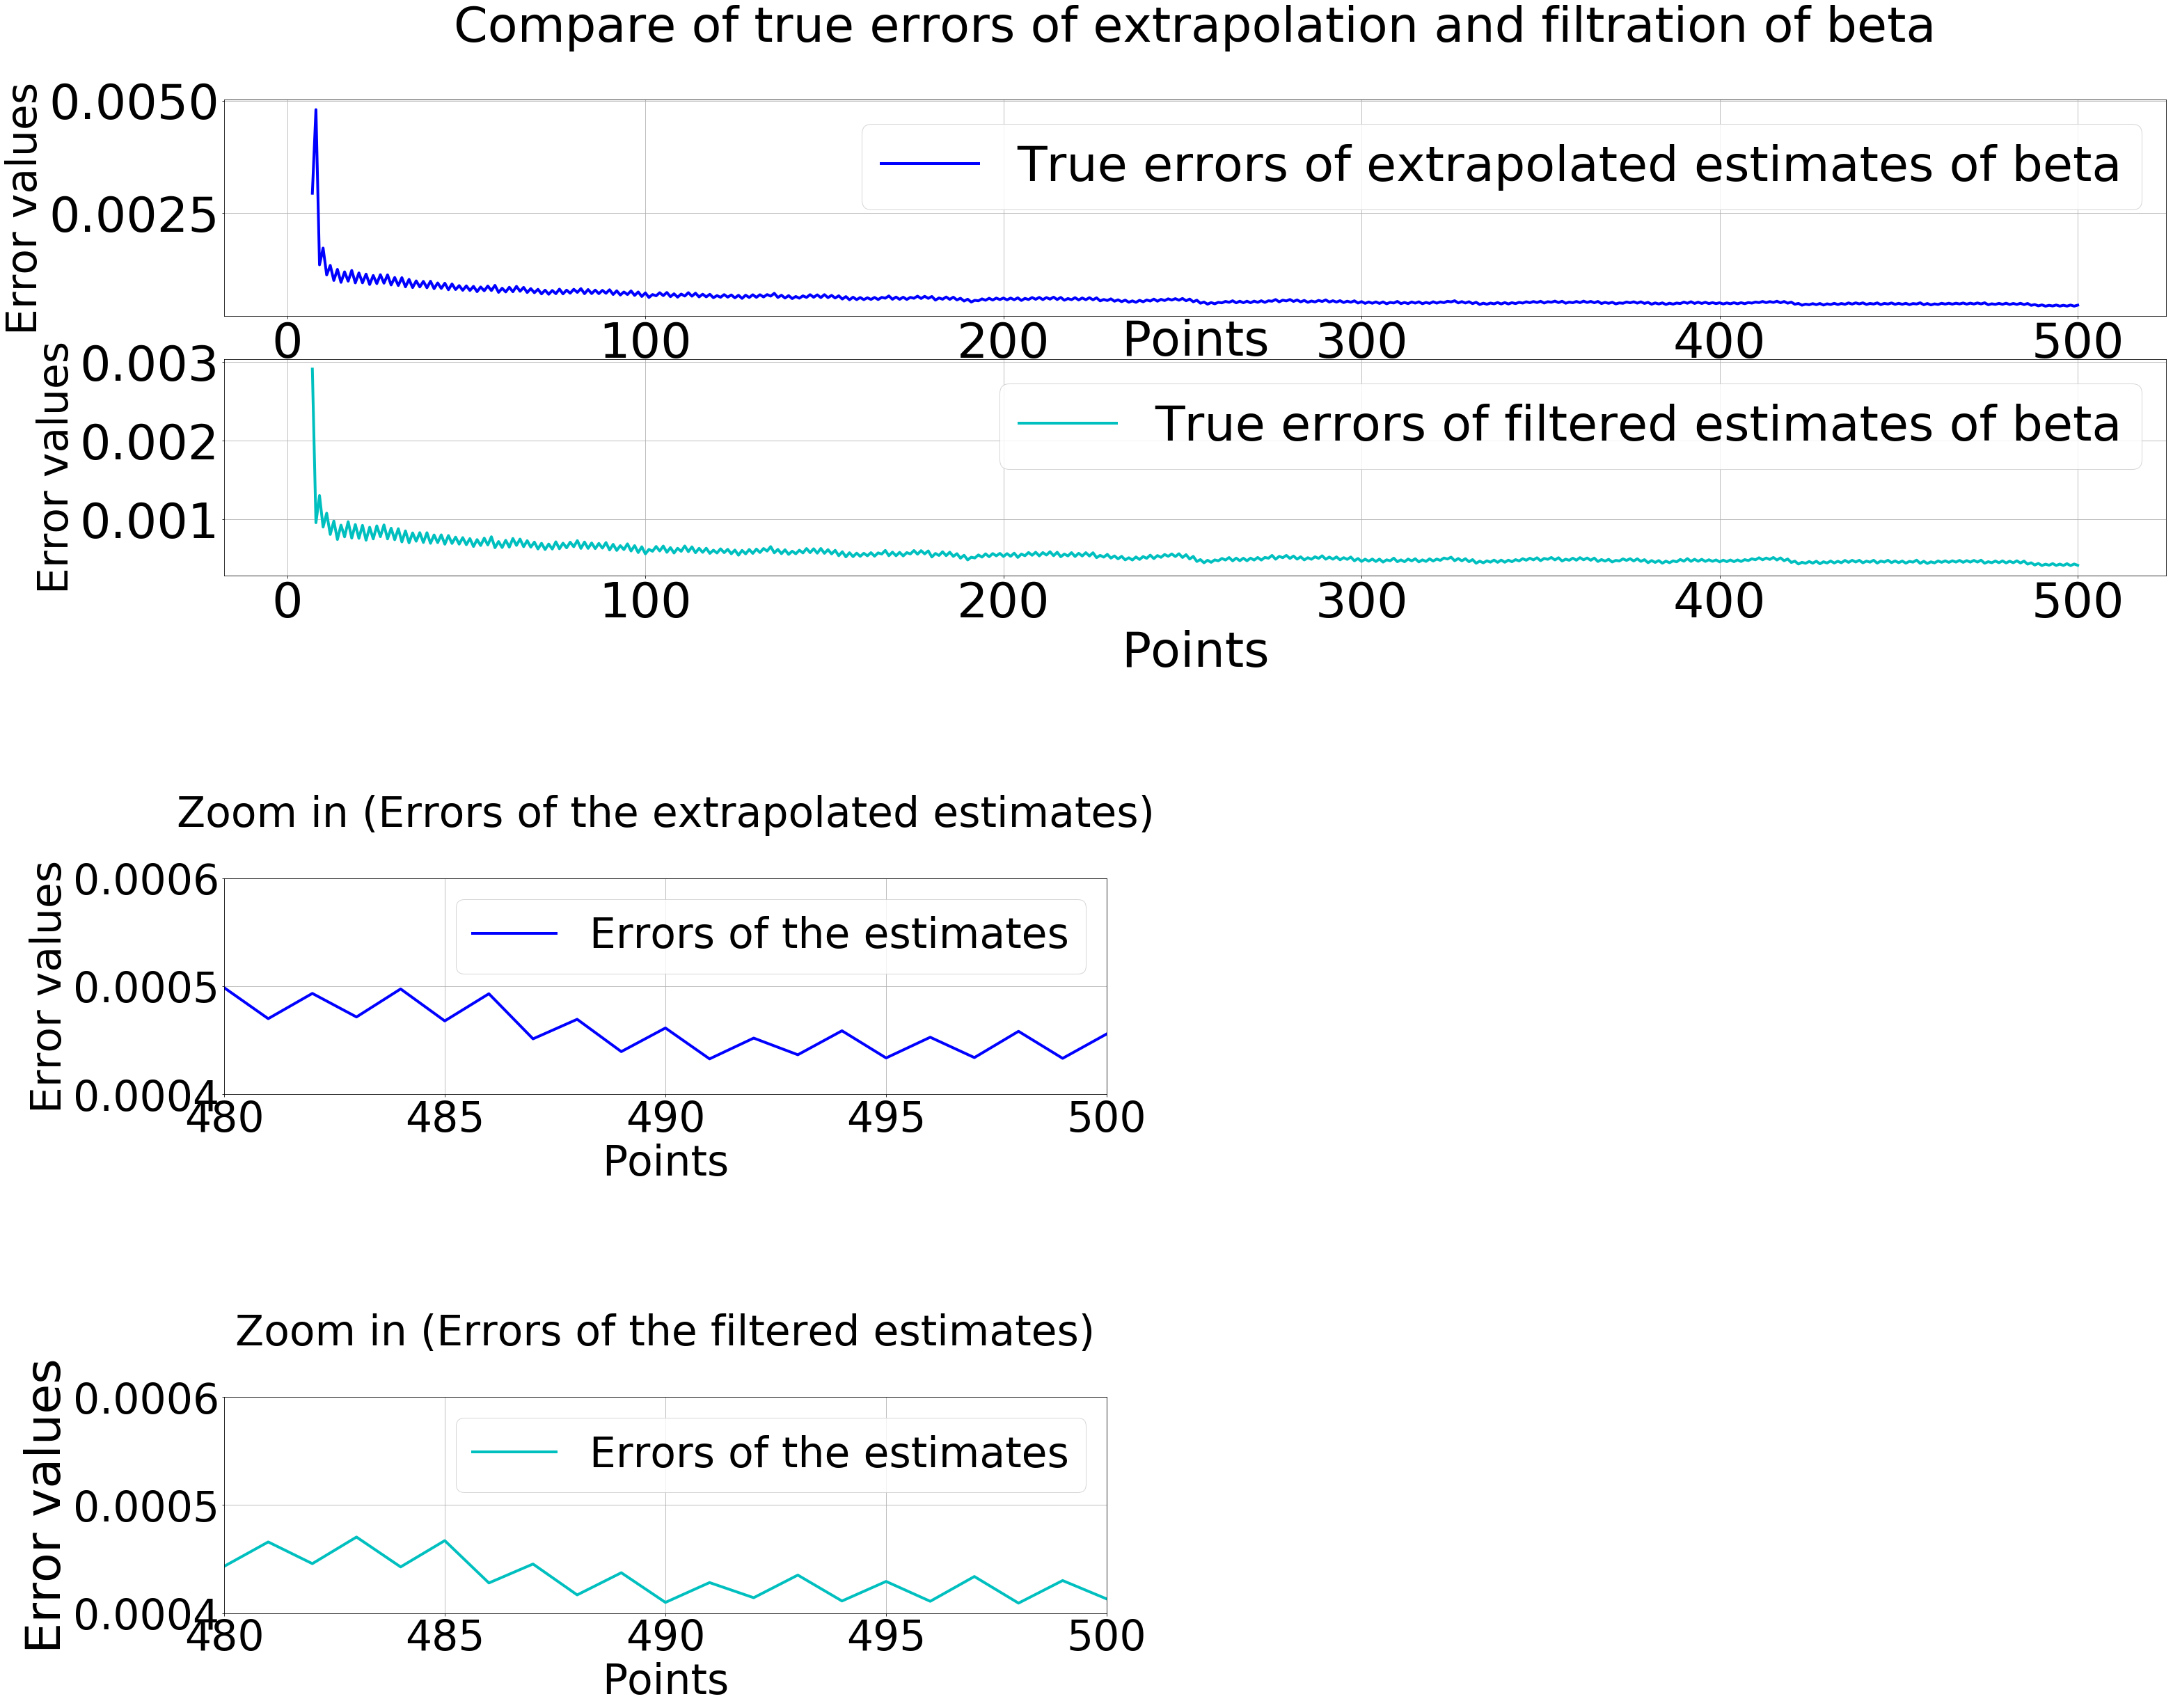

In [34]:
# Compare of true errors of extrapolation and filtration of beta
fig= plt.figure(1)

plt.subplot(612)
plt.plot(points[6:], Final_err_filt[1,6:], linewidth = 4, label = "True errors of filtered estimates of beta", color = "c")

plt.legend(fontsize = 70)
plt.rcParams["figure.figsize"] = (50,40)
plt.tick_params(labelsize = 70)
plt.grid()
plt.ylabel("Error values", fontsize = 60)
plt.xlabel("Points", fontsize = 70)
plt.title("Points", fontsize = 70)

plt.subplot(627)
plt.plot(points[6:], Final_err_extr[1,6:], linewidth = 4, label = "Errors of the estimates", color = "b")
plt.legend(fontsize = 60)
plt.rcParams["figure.figsize"] = (50,40)
plt.tick_params(labelsize = 60)
plt.ylabel("Error values", fontsize = 60)
plt.grid()
plt.xlim([480,500])
plt.ylim([0.0004,0.0006])
plt.xlabel("Points", fontsize = 60)
plt.title("Zoom in (Errors of the extrapolated estimates)\n", fontsize = 60)

plt.subplot(6,2,11)
plt.plot(points[6:], Final_err_filt[1,6:], linewidth = 4, label = "Errors of the estimates", color = "c")
plt.legend(fontsize = 60)
plt.rcParams["figure.figsize"] = (50,40)
plt.tick_params(labelsize = 60)
plt.grid()
plt.xlim([480,500])
plt.ylim([0.0004,0.0006])
plt.xlabel("Points", fontsize = 60)
plt.ylabel("Error values", fontsize = 70)
plt.title("Zoom in (Errors of the filtered estimates)\n", fontsize = 60)

plt.subplot(611)
plt.plot(points[6:], Final_err_extr[1,6:], linewidth = 4, label = "True errors of extrapolated estimates of beta", color = "b")
plt.legend(fontsize = 70)
plt.rcParams["figure.figsize"] = (50,40)
plt.tick_params(labelsize = 70)
plt.ylabel("Error values", fontsize = 60)
plt.grid()
plt.title("Compare of true errors of extrapolation and filtration of beta\n", fontsize = 70)

plt.show()

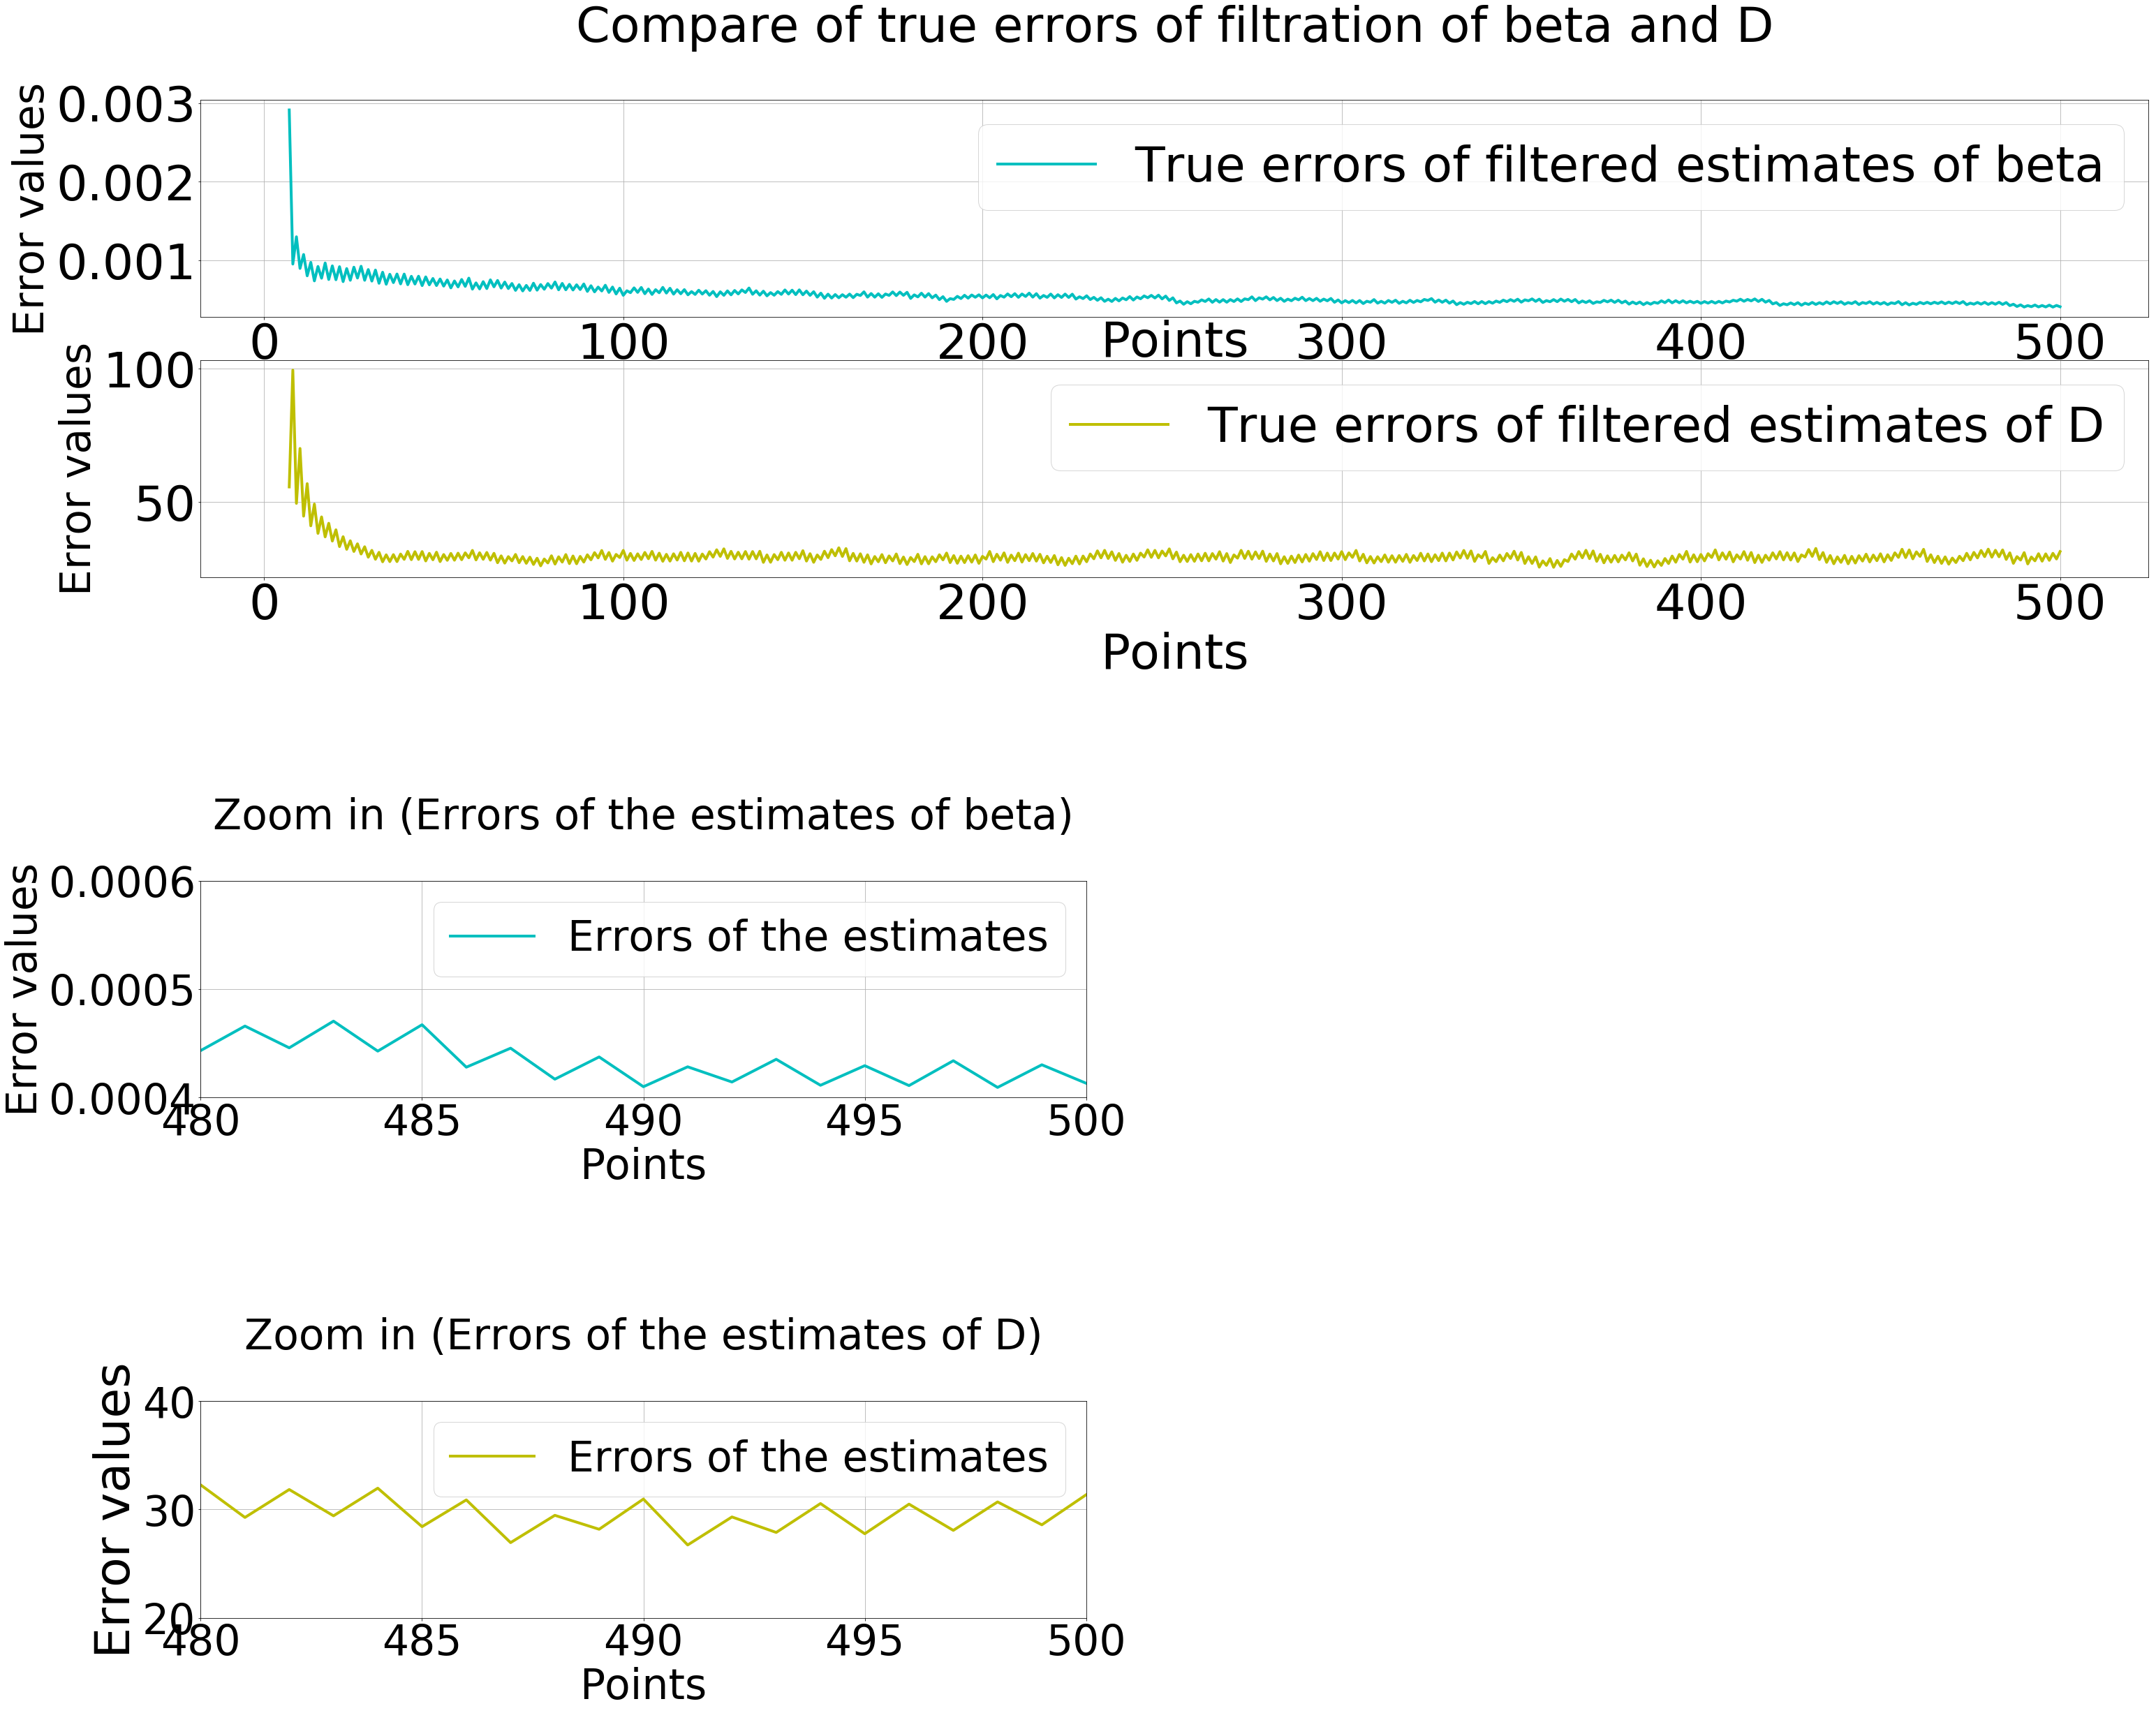

In [35]:
# Compare of true errors of filtration of betta and D
fig= plt.figure(1)

plt.subplot(612)
plt.plot(points[6:], Final_err_filt[0,6:], linewidth = 4, label = "True errors of filtered estimates of D", color = "y")

plt.legend(fontsize = 70)
plt.rcParams["figure.figsize"] = (50,30)
plt.tick_params(labelsize = 70)
plt.grid()
plt.ylabel("Error values", fontsize = 60)
plt.xlabel("Points", fontsize = 70)
plt.title("Points", fontsize = 70)

plt.subplot(627)
plt.plot(points[6:], Final_err_filt[1,6:], linewidth = 4, label = "Errors of the estimates", color = "c")
plt.legend(fontsize = 60)
plt.rcParams["figure.figsize"] = (50,30)
plt.tick_params(labelsize = 60)
plt.ylabel("Error values", fontsize = 60)
plt.grid()
plt.xlim([480,500])
plt.ylim([0.0004,0.0006])
plt.xlabel("Points", fontsize = 60)
plt.title("Zoom in (Errors of the estimates of beta)\n", fontsize = 60)

plt.subplot(6,2,11)
plt.plot(points[6:], Final_err_filt[0,6:], linewidth = 4, label = "Errors of the estimates", color = "y")
plt.legend(fontsize = 60)
plt.rcParams["figure.figsize"] = (50,30)
plt.tick_params(labelsize = 60)
plt.grid()
plt.ylabel("Error values", fontsize = 60)
plt.xlim([480,500])
plt.ylim([20,40])
plt.xlabel("Points", fontsize = 60)
plt.ylabel("Error values", fontsize = 70)
plt.title("Zoom in (Errors of the estimates of D)\n", fontsize = 60)

plt.subplot(611)
plt.plot(points[6:], Final_err_filt[1,6:], linewidth = 4, label = "True errors of filtered estimates of beta", color = "c")
plt.legend(fontsize = 70)
plt.rcParams["figure.figsize"] = (50,40)
plt.tick_params(labelsize = 70)
plt.ylabel("Error values", fontsize = 60)
plt.grid()
plt.title("Compare of true errors of filtration of beta and D\n", fontsize = 70)

plt.show()